In [ ]:
# === Ignorar advertencias ===
import warnings
warnings.filterwarnings('ignore')

# === Manejo del sistema y utilidades ===
import os
import ast
from itertools import product
from tqdm import tqdm

# === Manipulación de datos ===
import numpy as np
import pandas as pd

# === Visualización ===
import matplotlib.pyplot as plt

# === Preprocesamiento y métricas ===
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# === Diagnóstico estadístico ===
from statsmodels.stats.diagnostic import acorr_ljungbox

# === Redes neuronales (Keras / TensorFlow) ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import tensorflow as tf


In [ ]:
# Listar dispositivos disponibles
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"TensorFlow está utilizando la GPU: {devices}")
else:
    print("TensorFlow no está utilizando la GPU")

## Lectura de datos

In [ ]:
df = pd.read_csv('./datasets/data_treino_dv_df_2000_2010.csv')
df.head(1)

In [ ]:
df.columns = ['HORA','WIND_DIR_HOR','WIND_VEL_HOR','HUM_REL_MAX_ANT','HUM_REL_MIN_ANT','TEMP_MAX_ANT','TEMP_MIN_ANT','HUM_REL_HOR','PRES_ATM_NIV','PREC_HOR','RAFAGA_VIENTO','PRES_ATM_MAX_ANT','PRES_ATM_MIN_ANT']
df.head(2)

In [ ]:
df.info()

In [ ]:
df.drop(columns='HORA', inplace= True)

## Prueba de Modelos ANN

A continuación se realizan pruebas individuales de los modelos MLP, RNN y LSTM para obtener una idea de que parametros se ajustan mejor al problema. Posteriormente, por medio de un search más extensivo se buscara los parametros que ofrezcan mejores resultados.

### LSTM

In [ ]:
# 🧠 Genera secuencias de entrenamiento para RNN y LSTM
def create_rnn_sequences(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df.iloc[i:i+window_size]
        X.append(seq.drop(columns=[target_col]).values)
        y.append(df.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

In [44]:
target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24
extra = 1 * 24 # Datos adicionales para el testeo

data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
train_data = data_window.iloc[:T_hours]
test_data = data_window.iloc[T_hours:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
X_test_scaled = scaler.fit_transform(test_data.drop(columns=[target_col]))

train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
train_scaled[target_col] = train_data[target_col].values
test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
test_scaled[target_col] = test_data[target_col].values
scaled = pd.concat([train_scaled, test_scaled])

X, y = create_rnn_sequences(scaled, target_col, T_hours)
# (n_samples, timesteps, n_features)
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24, 168, 11), (24,), (24, 168, 11), (24,))

#### Ventana de 7 dias

1/1 [==============================] - 0s 166ms/step


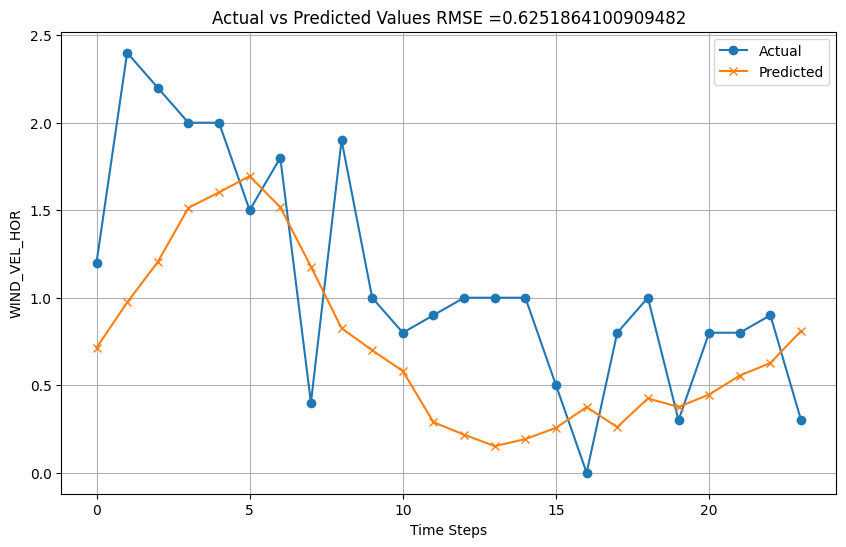

In [52]:
target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24
extra = 1 * 24 # Datos adicionales para el testeo

data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
train_data = data_window.iloc[:T_hours]
test_data = data_window.iloc[T_hours:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
X_test_scaled = scaler.fit_transform(test_data.drop(columns=[target_col]))

train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
train_scaled[target_col] = train_data[target_col].values
test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
test_scaled[target_col] = test_data[target_col].values
scaled = pd.concat([train_scaled, test_scaled])

X, y = create_rnn_sequences(scaled, target_col, T_hours)
# (n_samples, timesteps, n_features)
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

model =  Sequential([
  LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
  Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()



In [49]:
y_pred

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

### MLP

#### Ventana de tiempo 7 días

1/1 [==============================] - 0s 36ms/step


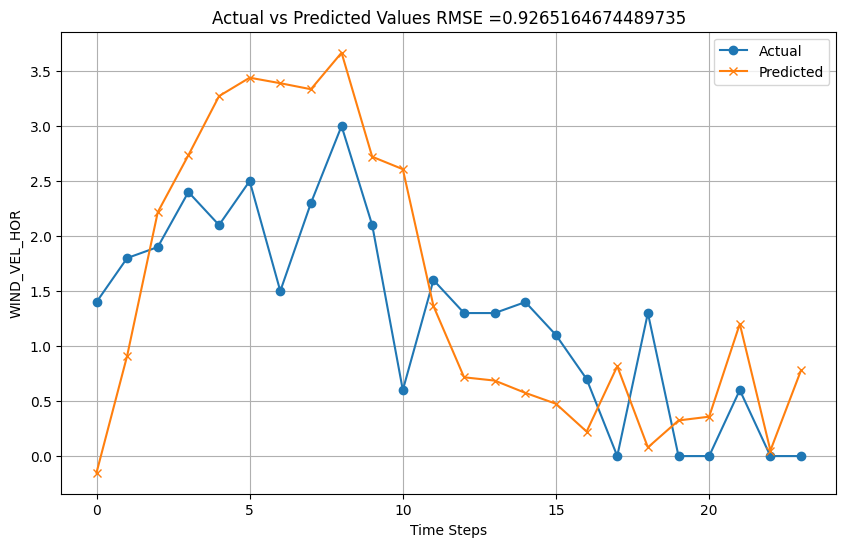

1/1 [==============================] - 0s 36ms/step


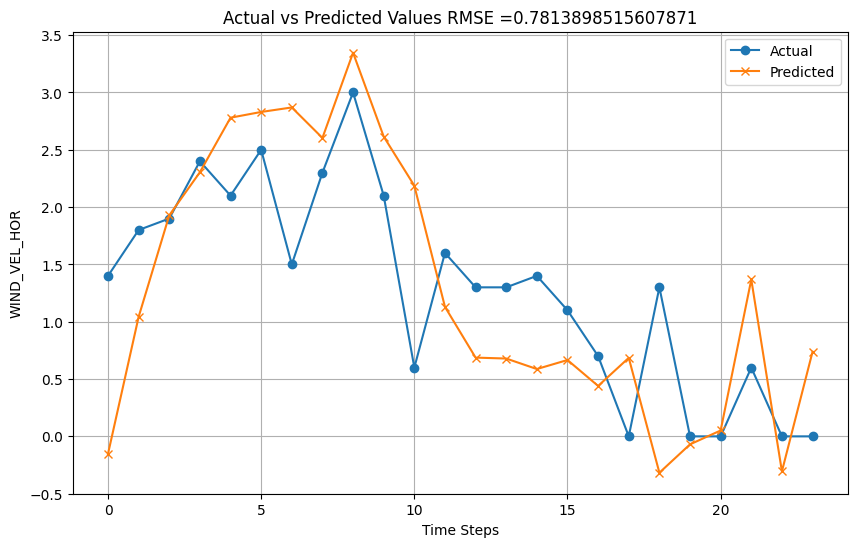

1/1 [==============================] - 0s 48ms/step


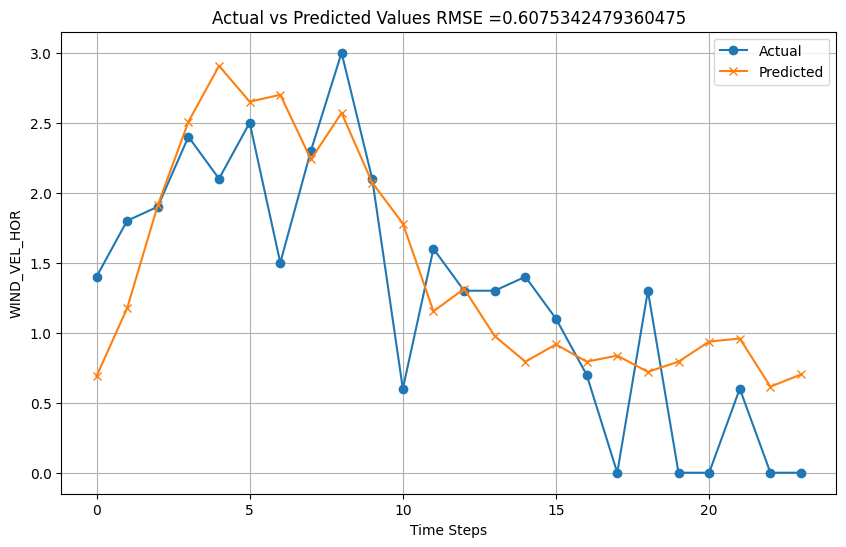

1/1 [==============================] - 0s 45ms/step


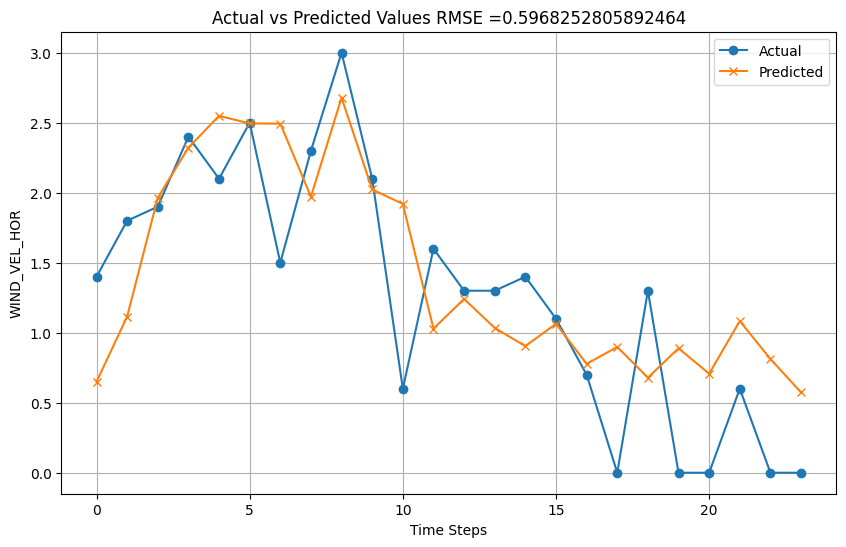

1/1 [==============================] - 0s 45ms/step


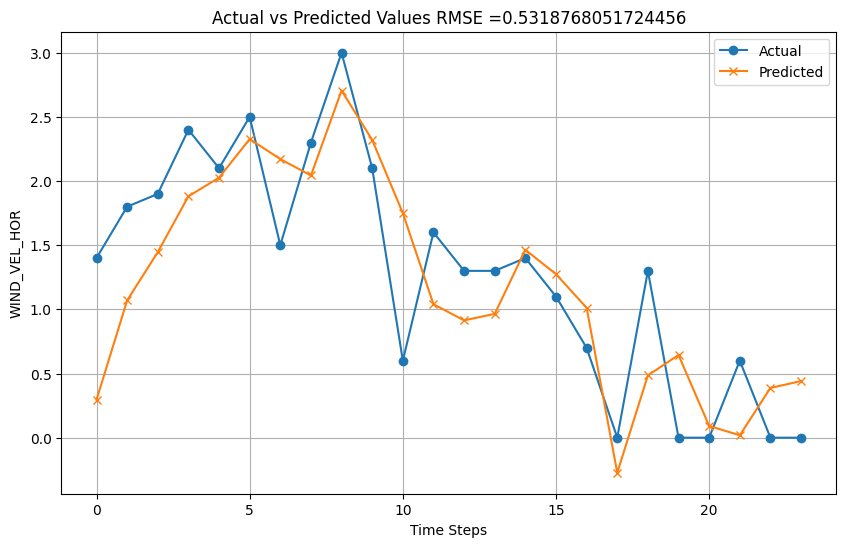

1/1 [==============================] - 0s 55ms/step


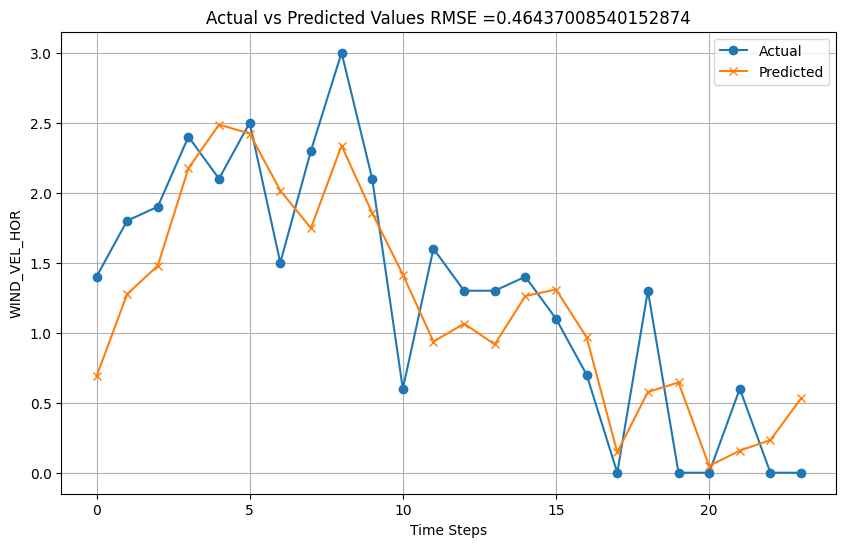

In [32]:
target_col = 'WIND_VEL_HOR'
window = 7
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 14 días

1/1 [==============================] - 0s 40ms/step


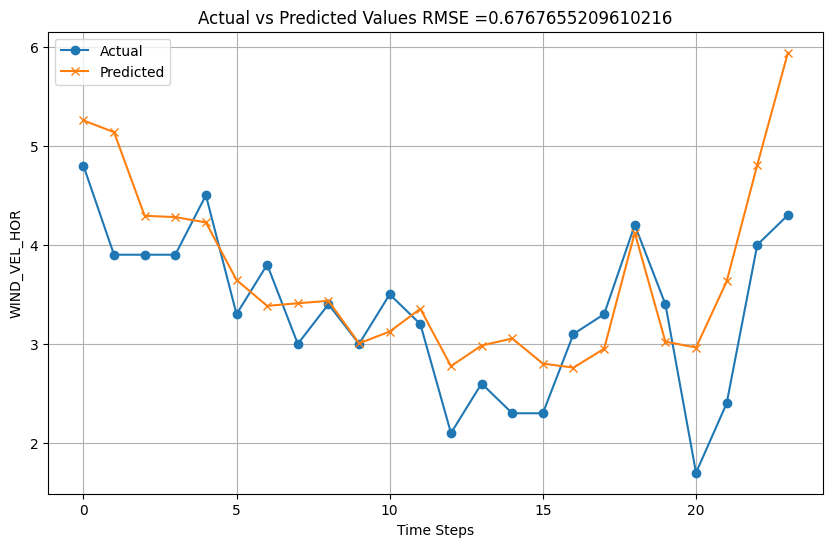

1/1 [==============================] - 0s 38ms/step


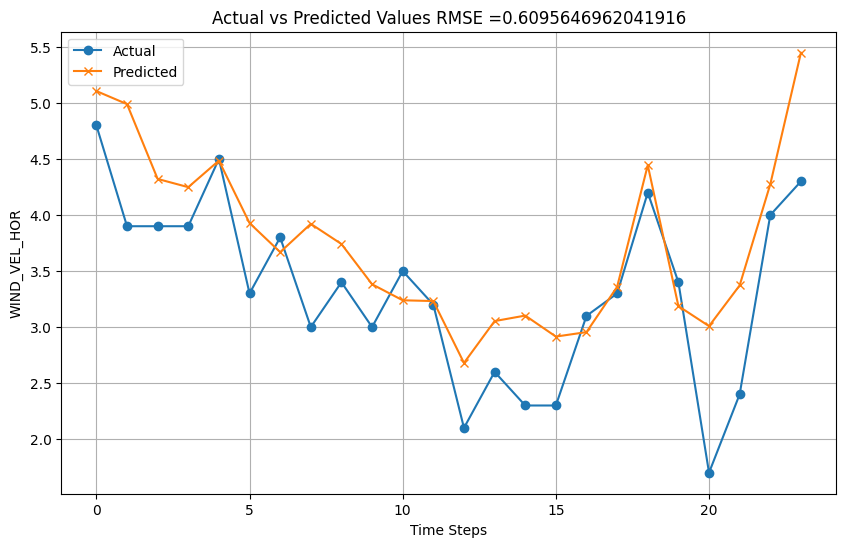

1/1 [==============================] - 0s 39ms/step


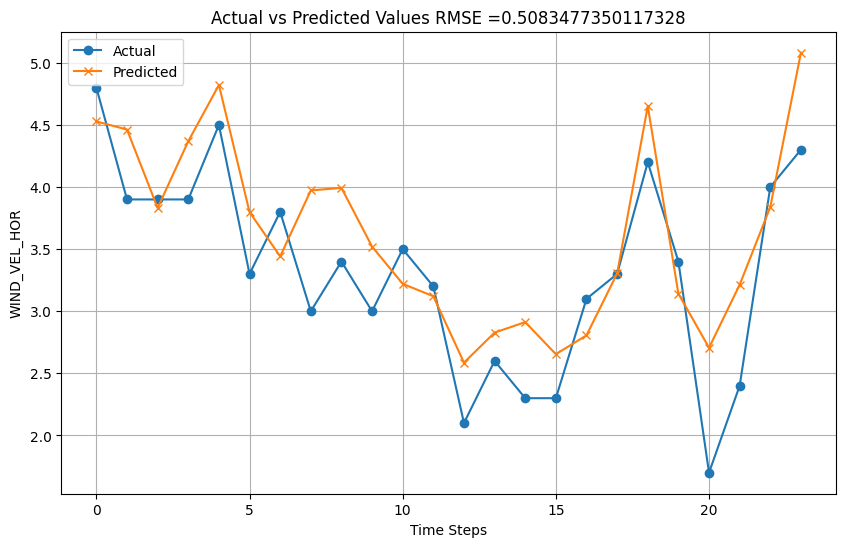

1/1 [==============================] - 0s 39ms/step


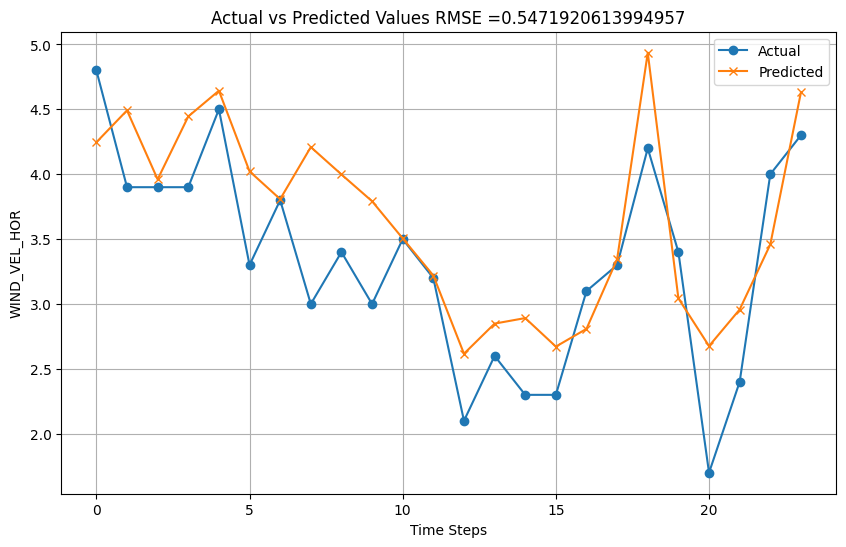

1/1 [==============================] - 0s 39ms/step


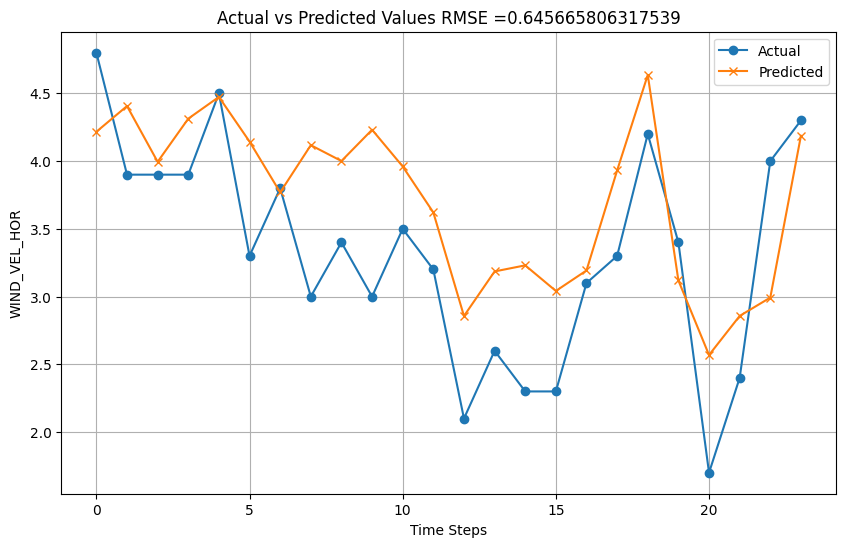

1/1 [==============================] - 0s 44ms/step


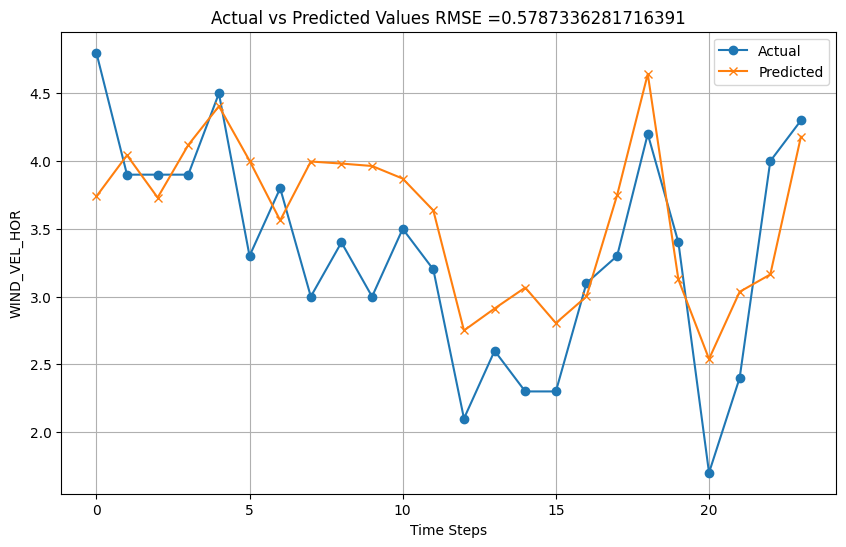

In [33]:
target_col = 'WIND_VEL_HOR'
window = 14
start = 1000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

#### Ventana de tiempo 21 días

1/1 [==============================] - 0s 23ms/step


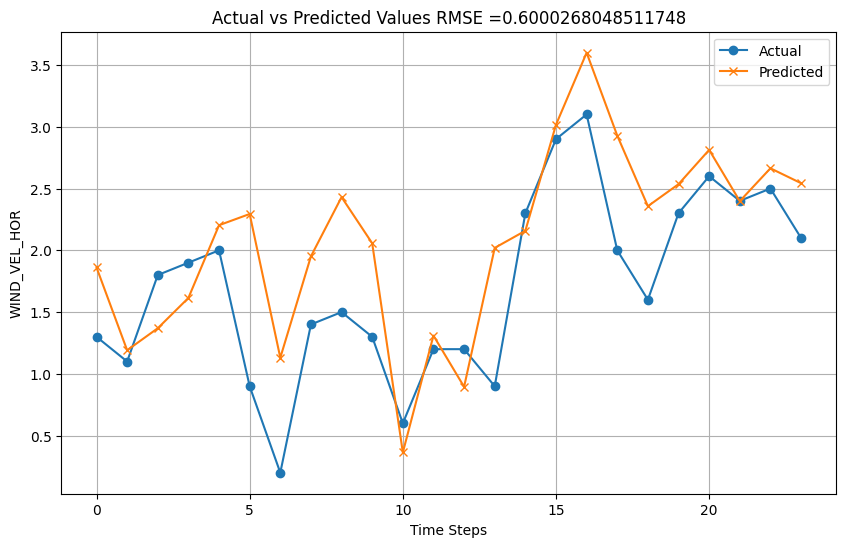

1/1 [==============================] - 0s 44ms/step


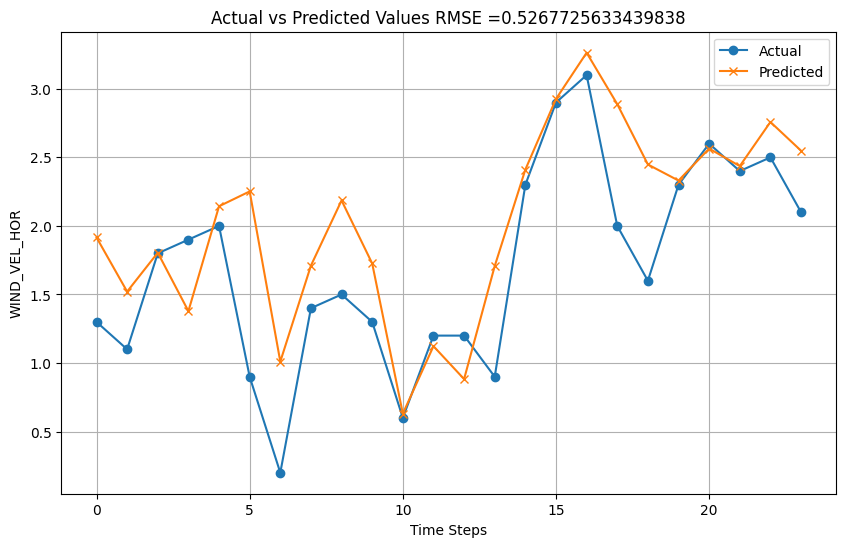

1/1 [==============================] - 0s 44ms/step


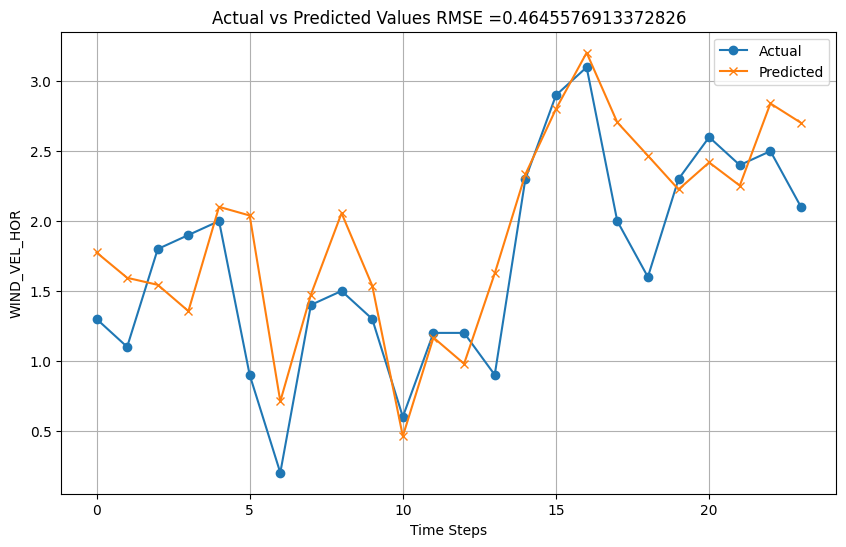

1/1 [==============================] - 0s 41ms/step


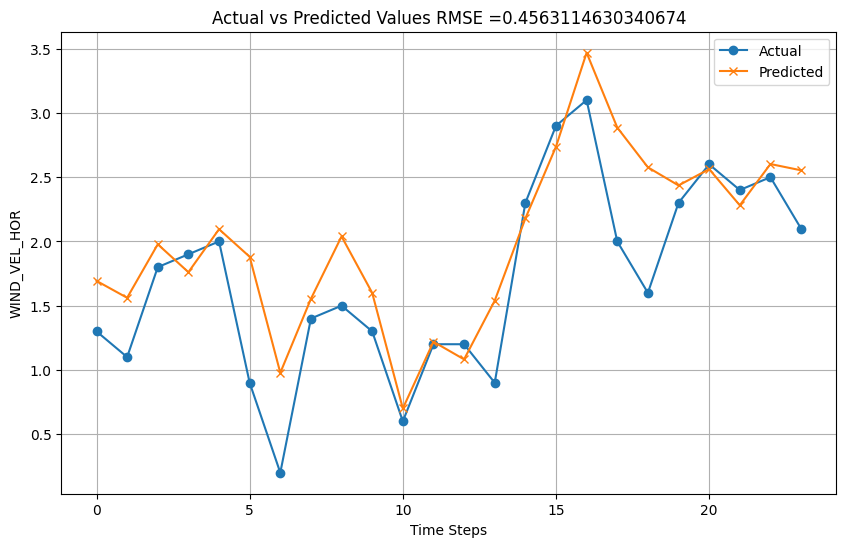

1/1 [==============================] - 0s 39ms/step


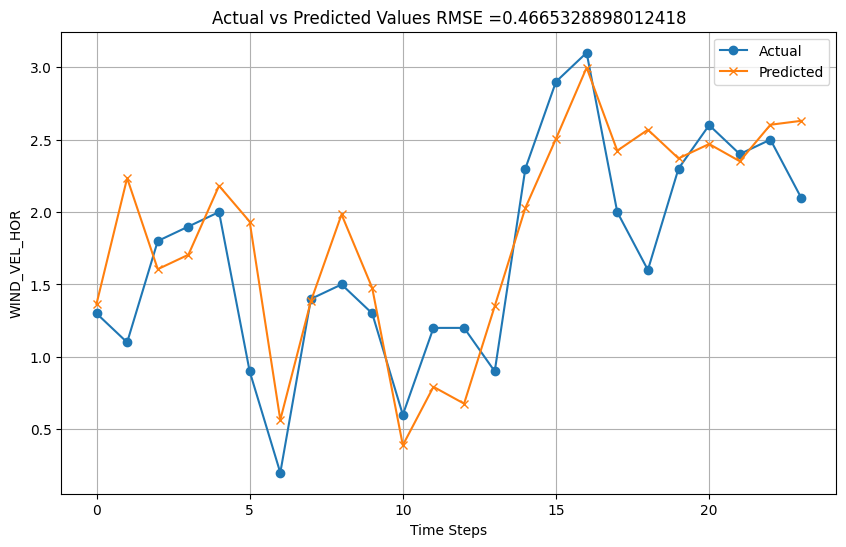

1/1 [==============================] - 0s 52ms/step


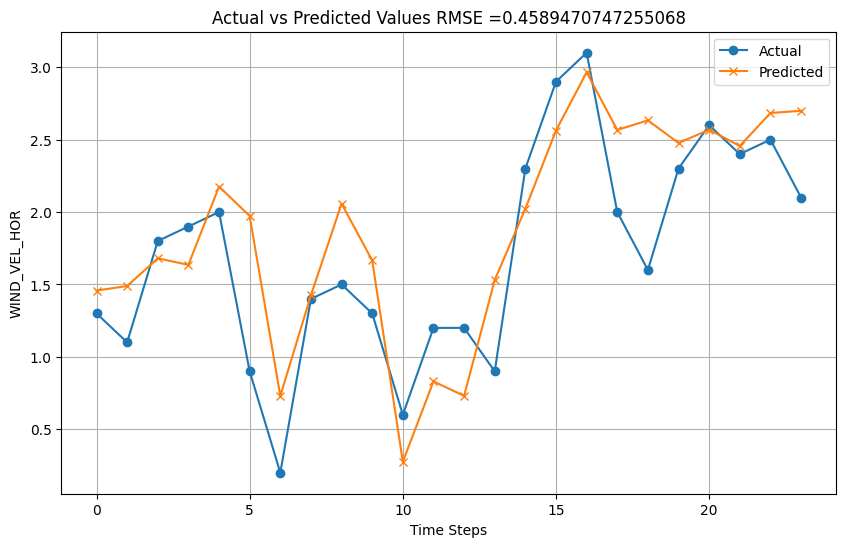

In [34]:
target_col = 'WIND_VEL_HOR'
window = 21
start = 2000 * 24 # A partir del día 30
T_hours = window * 24
test_hours = 1 * 24

# Train Test +  Escalado
train = df.iloc[start: start + T_hours]
test = df.iloc[start + T_hours: start + T_hours + test_hours]

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.drop(columns=[target_col])
y_test = test[target_col]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Duplicando neuronas 1 sola capa
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Adicionando otra capa oculta
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(16, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

## Mas neuronas en las capas
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'relu'), #Capa oculta
  Dense(32, activation = 'relu'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(16, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()

##Modificando funciones de activacion + mas neuronas en las capas
#Sigmoid disminui la capacidad de aprendizaje
model = Sequential([
  Input(shape=(X_train.shape[1])),
  Dense(64, activation = 'tanh'), #Capa oculta
  Dense(32, activation = 'tanh'), #Capa oculta
  Dense(1) #Capa salida
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_test

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Values RMSE ={rmse_test}')
plt.xlabel('Time Steps')
plt.ylabel('WIND_VEL_HOR')
plt.legend()
plt.grid()
plt.show()